<a href="https://colab.research.google.com/github/rahhul/GANs/blob/master/t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-distributed Stochastic Neighbor Embedding (t-SNE) 

**t-SNE on Fashion MNIST**<br>
t-SNE is a dimensionality reduction technique for high-dimensional data.<br>
The cost function of t-SNE algorithm is non-convex. There are multiple local minima and multiple runs will generate different results.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# imports

import os
import sys
assert sys.version_info >= (3, 5)

# Scikit Learn
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Check GPU availaility
physical_devices = tf.config.list_logical_devices('GPU')
print("Num Devices: ", len(physical_devices))

print(tf.__version__)
print(keras.__version__)

# common imports
import numpy as np
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)


Num Devices:  0
2.1.0
2.2.4-tf


### Load MNIST data

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


**Reshape a 3D array into a 2D array**

In [5]:
# reshape into vectors

X_train = X_train.reshape(X_train.shape[0], 784)

print(X_train.shape)

(60000, 784)


In [0]:
import time
import pandas as pd
import matplotlib.patheffects as PathEffects

import seaborn as sns
sns.set_style('darkgrid')
# sns.set_palette('muted')

In [0]:
# Random State Variable (random seed)

RS = 123

**Utility function to help visualise**

In [0]:
# utility function

def visualise_results(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # show labels
    txts = []

    for i in range(num_classes):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i))

        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

Training data has 60,000 images.<br>
PCA on a subset of 20,000 images

In [22]:
x_subset = X_train[:20000]
y_subset = y_train[:20000]

# check coverage of all 10 classes
print(np.unique(y_subset))
print(x_subset.shape)

[0 1 2 3 4 5 6 7 8 9]
(20000, 784)


## Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA

In [24]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

print('PCA complete! Time elapsed: {} seconds'.format(time.time() - time_start))

PCA complete! Time elapsed: 0.7830796241760254 seconds


Load 4 generated pca components into a Pandas Dataframe

In [25]:
pca_result.shape

(20000, 4)

In [26]:
pca_df = pd.DataFrame(columns=['pca1', 'pca2', 'pca3', 'pca4'])

pca_df['pca1'] = pca_result[:, 0]
pca_df['pca2'] = pca_result[:, 1]
pca_df['pca3'] = pca_result[:, 2]
pca_df['pca4'] = pca_result[:, 3]

print(pca_df.head())
print('\033[1m' + 'Variance per principal component: ', pca.explained_variance_ratio_)

       pca1      pca2      pca3      pca4
0 -0.534464  6.422375 -4.696864  1.037060
1  5.536298 -1.699861 -0.949181  1.382459
2 -2.795199 -4.355145  0.406203  0.817859
3  0.164155 -3.854738  0.812159  1.460456
4  3.220793 -4.661079 -2.911092 -1.084523
Variance per principal component:  [0.29021338 0.17787437 0.06015076 0.04975868]


In [0]:
top_two_components = pca_df[['pca1', 'pca2']]

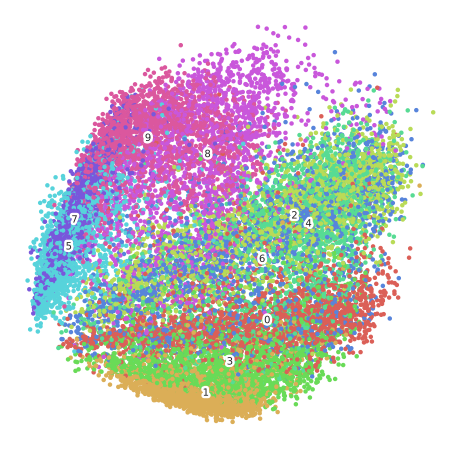

In [43]:
# visualise

visualise_results(top_two_components.values, y_subset);

## t-SNE

t-SNE is computationally taxing to run on the entire dataset. Instead, here it is run on the 50 components generated by PCA.

In [0]:
from sklearn.manifold import TSNE

In [30]:
# t-sne with default parameters

time_start = time.time()

pca_50 = PCA(n_components=50)

pca_result_50 = pca_50.fit_transform(x_subset)

print("Time elapsed: {} seconds".format(time.time() - time_start))

Time elapsed: 1.215017318725586 seconds


In [31]:
cumulative_ratio_explained = np.sum(pca_50.explained_variance_ratio_)

print("\033[1m" + "Cumulative variance explained by 50 components: ", cumulative_ratio_explained)

Cumulative variance explained by 50 components:  0.86252993


In [0]:
# t-SNE

tsne = TSNE(random_state=RS, init='pca', perplexity=100, n_jobs=-1, verbose=1)


In [47]:
# Apply t-sne on pca_50

time_start = time.time()

fashion_pca_tsne = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.183s...
[t-SNE] Computed neighbors for 20000 samples in 16.872s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

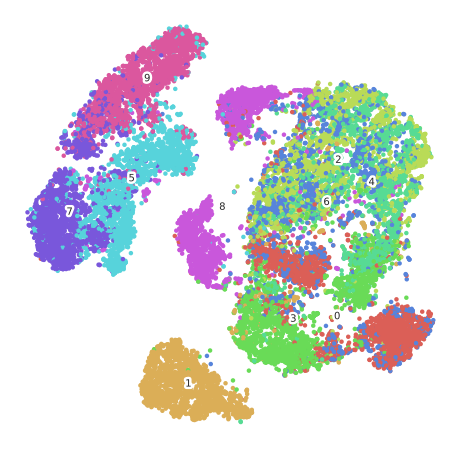

In [48]:
visualise_results(fashion_pca_tsne, y_subset);

In [49]:
tsne.kl_divergence_

1.484046459197998